<a href="https://colab.research.google.com/github/hashimmg/Jax_IB/blob/notebooks/Journal_bearing_mixing_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
cd drive/MyDrive/Jax_IB-main_correct/

/content/drive/MyDrive/Jax_IB-main_correct


# New Section

In [14]:
!pwd
!pip install -e .

/content/drive/MyDrive/Jax_IB-main_correct
Obtaining file:///content/drive/MyDrive/Jax_IB-main_correct
  Preparing metadata (setup.py) ... done
  Running setup.py develop for jax-IB


In [16]:
cd /content/drive/MyDrive/jax-cfd-main/

/content/drive/MyDrive/jax-cfd-main


In [17]:

!pip install -e .


Obtaining file:///content/drive/MyDrive/jax-cfd-main
  Preparing metadata (setup.py) ... done
  Running setup.py develop for jax-cfd


In [22]:
!pip install jax-md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 22.2 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=968216b464c400623adf9ecfd5b1b6d00d2bcb7cb8c08b13e558722a574f8b88
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [18]:
cd ../Jax_IB-main_correct/

/content/drive/MyDrive/Jax_IB-main_correct


In [19]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/jax-cfd-main')

In [53]:
sys.path.insert(0,'/content/drive/MyDrive/Jax_IB-main_correct/Jax_IB')

In [20]:
!pwd

/content/drive/MyDrive/Jax_IB-main_correct


In [23]:
import Jax_IB
import jax
import jax.numpy as jnp
from Jax_IB.base import particle_class as pc
import Jax_IB.base as ib
import jax_cfd.base as cfd
import Jax_IB.MD as MD
from jax import random
from jax_md import space, quantity

In [33]:
import Jax_IB.base.grids as grids
import Jax_IB.base.boundaries as boundaries
import Jax_IB.base.advection as advection
import Jax_IB.base.equations as equations
import Jax_IB.base.IBM_Force as IBM_Force
import Jax_IB.base.convolution_functions as convolution_functions
import Jax_IB.MD.CFD_MD_coupling as CFD_MD_coupling

In [62]:
boundaries.new_periodic_boundary_conditions

<function Jax_IB.base.boundaries.new_periodic_boundary_conditions(ndim: int, bc_vals: Optional[Sequence[Tuple[float, float]]], time_stamp: Optional[float], bc_fn: Callable[..., Optional[float]]) -> Jax_IB.base.boundaries.ConstantBoundaryConditions>

In [25]:
def Bc_f1(t):
    return A + B*(C*jnp.cos(freq*t)+D*jnp.sin(freq*t))

def Bc_f(t):
    return 0.0

def Bc_f_Y(t):
    return 0.0

def velocity_boundary_coditions(A,B,C,D,freq):
    bc_fns = [Bc_f for a,b,c,d,f in zip(A,B,C,D,freq)]
    vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
    vy_bc=((0.0, 0.0), (0, 0.0))
    velocity_bc = (boundaries.Moving_wall_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.Moving_wall_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

    return velocity_bc

def periodic_velocity_boundary_coditions(A,B,C,D,freq):
    bc_fns = [Bc_f for a,b,c,d,f in zip(A,B,C,D,freq)]
    vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
    vy_bc=((0.0, 0.0), (0, 0.0))

    velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))
    return velocity_bc

def Displacement_Foil_Fourier_Dotted_Mutliple(parameters,t):

    alpha0=jnp.array(list(list(zip(*parameters))[0]))
    f =jnp.array(list(list(zip(*parameters))[1]))
    phi = jnp.array(list(list(zip(*parameters))[2]))
    alpha = jnp.array(list(list(zip(*parameters))[3]))
    beta = jnp.array(list(list(zip(*parameters))[4]))
    p = jnp.array(list(list(zip(*parameters))[5]))

    size_parameters = alpha.shape[1]
    N_particles =len(alpha)

    ## Create an array of the size (nparticles, nparameters)
    frequencies = jnp.array([jnp.arange(1,size_parameters+1)]*N_particles)

    ## multiply and add arrays

    inside_function =jnp.add(2*jnp.pi*t*frequencies*f.reshape(N_particles,1),phi.reshape(N_particles,1))

    alpha_1 = (alpha*jnp.sin(inside_function)).sum(axis=1)

    alpha_1 += p*(beta*jnp.cos(inside_function)).sum(axis=1)


    return jnp.array([-alpha0*t,alpha_1])


def rotation_Foil_Fourier_Dotted_Mutliple(parameters,t):
    #alpha0,f,phi,alpha,beta,p = parameters
    alpha0=jnp.array(list(list(zip(*parameters))[0]))
    f =jnp.array(list(list(zip(*parameters))[1]))
    phi = jnp.array(list(list(zip(*parameters))[2]))
    alpha = jnp.array(list(list(zip(*parameters))[3]))
    beta = jnp.array(list(list(zip(*parameters))[4]))
    p = jnp.array(list(list(zip(*parameters))[5]))

    size_parameters = alpha.shape[1]
    N_particles =len(alpha)

    ## Create an array of the size (nparticles, nparameters)
    frequencies = jnp.array([jnp.arange(1,size_parameters+1)]*N_particles)

    ## multiply and add arrays

    inside_function =jnp.add(2*jnp.pi*t*frequencies*f.reshape(N_particles,1),phi.reshape(N_particles,1))

    alpha_1 = (alpha*jnp.sin(inside_function)).sum(axis=1)

    alpha_1 += p*(beta*jnp.cos(inside_function)).sum(axis=1)

    #if N_particles>1:
    return alpha0*t + alpha_1

def rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED(parameters,t):
    #alpha0,f,phi,alpha,beta,p = parameters
    alpha0=jnp.array(list(list(zip(*parameters))[0]))
    f =jnp.array(list(list(zip(*parameters))[1]))
    phi = jnp.array(list(list(zip(*parameters))[2]))
    alpha = jnp.array(list(list(zip(*parameters))[3]))
    beta = jnp.array(list(list(zip(*parameters))[4]))
    theta_av = jnp.array(list(list(zip(*parameters))[5]))
    p = jnp.array(list(list(zip(*parameters))[6]))

    size_parameters = alpha.shape[1]
    N_particles =len(alpha)

    ## Create an array of the size (nparticles, nparameters)
    frequencies = jnp.array([jnp.arange(1,size_parameters+1)]*N_particles)

    ## multiply and add arrays

    inside_function =jnp.add(2*jnp.pi*t*frequencies*f.reshape(N_particles,1),phi.reshape(N_particles,1))

    alpha_1 = (alpha*jnp.sin(inside_function)).sum(axis=1)

    alpha_1 += p*(beta*jnp.cos(inside_function)).sum(axis=1)

    inside_function2 =jnp.add(2*jnp.pi*frequencies,phi.reshape(N_particles,1))

    alpha_2 = (alpha*jnp.sin(inside_function2)).sum(axis=1)

    alpha_2 += p*(beta*jnp.cos(inside_function2)).sum(axis=1)

    inside_function3 =jnp.add(2*jnp.pi*frequencies*0.0,phi.reshape(N_particles,1))

    alpha_3 = (alpha*jnp.sin(inside_function3)).sum(axis=1)

    alpha_3 += p*(beta*jnp.cos(inside_function3)).sum(axis=1)


    #if N_particles>1:
    return theta_av*(alpha0*t + alpha_1)/(alpha0 + alpha_2-alpha_3)
    #return (alpha0 + alpha_2)
    #else:
    #    return (alpha0*t + alpha_1)[0]


In [26]:
def initiate_particles_upper_lower_Off(key,key1,key2,num_distrib,num_outer_bc,pp,CC):
    Outer_Rad = pp[1][0]
    Inner_Rad = pp[0][0]
    particle_center = CC[0]
    particle_center_OUTER = CC[1]
    # Outer cylinder force points
    theta = jnp.linspace(0,2*jnp.pi,num_outer_bc)
    pos_fixed_outer=jnp.moveaxis(jnp.array([Outer_Rad*jnp.cos(theta)+particle_center_OUTER[0],Outer_Rad*jnp.sin(theta)+particle_center_OUTER[1] ]),0,-1)

    # Inner cylinder point
    pos_fixed_inner = jnp.array([[particle_center[0],particle_center[1]]])

    # Interior passive particles
    eps_val=1e-2
    theta_p_upper = random.uniform(key,shape=(num_distrib,),minval=0.,maxval=jnp.pi)
    p1 = Inner_Rad
    distance = particle_center_OUTER[0] - particle_center[0]
    p2 =  jnp.sqrt(Outer_Rad**2 + distance**2 - 2*Outer_Rad*distance*jnp.cos(jnp.pi-theta_p_upper))
    R_p_upper = p1 + random.uniform(key1,shape=(num_distrib,),minval=0.+eps_val,maxval=1.-eps_val)*(p2-p1)

    updated_angle = jnp.arctan2((Outer_Rad*jnp.sin(theta_p_upper)),(distance + Outer_Rad*jnp.cos(theta_p_upper)))
    pos_upper = jnp.moveaxis(jnp.array([R_p_upper*jnp.cos(updated_angle)+particle_center[0],R_p_upper*jnp.sin(updated_angle)+particle_center[1] ]),0,-1)


    pos_lower = jnp.moveaxis(jnp.array([R_p_upper*jnp.cos(updated_angle)+particle_center[0],-R_p_upper*jnp.sin(updated_angle) +particle_center[1]]),0,-1)


    Pos_all = jnp.concatenate([pos_upper,pos_lower,pos_fixed_outer,pos_fixed_inner])

    num_spec = 2+1
    rad = 4
    Rad_outer_wall = Outer_Rad*2*jnp.pi/num_outer_bc

    r0_array=jnp.array([[0.,Rad_outer_wall,Inner_Rad],[Rad_outer_wall,0.,0.],[Inner_Rad,0.0,0.0]])
    h_array=jnp.array([[0.,5.0,5.0],[5.0,0.,0.],[5.0,0.0,0.0]])
    h_array=jnp.array([[0.,0.6,0.6],[0.60,0.,0.],[0.60,0.0,0.0]])

    is_mobile = jnp.ones(2*num_distrib)
    is_mobile=jnp.concatenate([is_mobile, jnp.zeros([num_outer_bc+1])])

    return Pos_all,is_mobile,r0_array,h_array

In [27]:
def foil_XY_ELLIPSE(geometry_param,theta):
      A = geometry_param[0]
      B = geometry_param[1]

      ntheta=80

      xt = jnp.linspace(-A,A,ntheta)
      yt = B/A*jnp.sqrt(A**2-xt**2)
      xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
      yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)


      return jnp.append(xt,xt_2),jnp.append(yt,yt2)


def foil_XY_circle(geometry_param,theta):
      A = geometry_param[0]
      B = geometry_param[1]
      ntheta = 80#150 (150 worked well)
      #xt = jnp.array(theta[:len(theta)//2]/(jnp.pi))
      theta = jnp.linspace(0,1.98*jnp.pi,ntheta)
      xt = A*jnp.cos(theta)
      yt = A*jnp.sin(theta)


      return xt,yt

def Internal_Post_Processing_MD(all_variables,dt):
    pressure = all_variables.pressure
    velocity = all_variables.velocity
    particles = all_variables.particles
    particle_center = particles.particle_center
    geom_param = particles.geometry_param
    drag_variables = all_variables.Drag
    current_t = velocity[0].bc.time_stamp
    Step_count = all_variables.Step_count
    MD_var = all_variables.MD_var
    Displacement_EQ = particles.Displacement_EQ
    displacement_param = particles.displacement_param
    New_eq = lambda t:Displacement_EQ(displacement_param,t)
    dx_dt = jax.jacrev(New_eq)

    Rotation_EQ = particles.Rotation_EQ
    rotation_param = particles.rotation_param
    New_eq_rot = lambda t:Rotation_EQ(rotation_param,t)
    domega_dt = jax.jacrev(New_eq_rot)


    U0 =dx_dt(current_t)

    Drag = [*U0,*domega_dt(current_t),*particle_center,*geom_param]
    return pc.All_Variables(particles,velocity,pressure,Drag,Step_count,MD_var)

In [52]:
#-- Flow conditions
density = 1.0
viscosity = 0.05
dt=8e-5
inner_steps = 1000#1800#20#450#1500#1300
outer_steps = 10#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)


#-- CFD Boundary condition parameters
freq=[0.]*4
A=[0.]*4
B=[0.]*4
C=[0.]*4
D=[0.]*4

domain = ((0,5.),(0,5.0))
size=(300,300)
grid = grids.Grid(size, domain=domain)

velocity_bc = periodic_velocity_boundary_coditions(A,B,C,D,freq)

def convect(v):
  return tuple(
    advection.advect_upwind(u, v, dt) for u in v)


#-- Initial velocity profile
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)



velocity_fns = (vx_fn, vy_fn)
v0 = tuple(grid.eval_on_mesh(v_fn, offset) for v_fn, offset in zip(velocity_fns, grid.cell_faces))
print(v0)
v0 = tuple(
      grids.GridVariable(u, bc) for u, offset,
      bc in zip(v0, grid.cell_faces, velocity_bc))
print(v0[0])
#-- Initial Pressure Profile

pressure0 = grids.GridVariable(grids.GridArray(jnp.zeros_like(v0[0].data), grid.cell_center, grid), boundaries.get_pressure_bc_from_velocity(v0))

print(pressure0) ## need to fix pressure boundary condition

(GridArray(data=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32, weak_type=True), offset=(1.0, 0.5), grid=Grid(shape=(300, 300), step=(0.016666666666666666, 0.016666666666666666), domain=((0.0, 5.0), (0.0, 5.0)))), GridArray(data=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32, weak_type=True), offset=(0.5, 1.0), grid=Grid(shape=(300, 300), step=(0.016666666666666666, 0.016666666666666666), domain=((0.0, 5.0), (0.0, 5.0)))))
GridVariable(array=GridArray(data=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ..

In [29]:
#-- Immersed objects
rad_ratio = 0.5
alpha0 = [jnp.pi/2]*2
n_terms = 1
alpha_1 = [0.0]*n_terms
beta_1 = [0.0]*n_terms
alpha_2 = [0.0]*n_terms
beta_2 = [0.0]*n_terms
frequency = 1.0
theta_out = jnp.pi/2*1.9#
omega = 3.0
p_H = 1.
p_P = 1.

particle_geometry_param = [[1.*rad_ratio,1.*rad_ratio],[1.0,1.0]]
particle_center_position=[[2.5,2.5],[2.5,2.5]]
displacement_param=[[0.,0.,0.,jnp.array([1.]),jnp.array([1.]),0.],
            [0.,0.,0.,jnp.array([1.]),jnp.array([1.]),0]]#,[jnp.array([1,2,5]),3]]

rotation_param=[[alpha0[0],frequency,0.,jnp.array(alpha_1),jnp.array(beta_1),theta_out*omega,p_H],
            [alpha0[1],frequency,0.,-jnp.array(alpha_2),jnp.array(beta_2),theta_out,p_P]]

Displacement_EQ = Displacement_Foil_Fourier_Dotted_Mutliple
Rotation_EQ = rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED
Shape_fn = foil_XY_circle
mygrids= pc.Grid1d(2, domain= (0, 2*jnp.pi))

particles =  pc.particle(jnp.array(particle_center_position),jnp.array(particle_geometry_param),displacement_param,rotation_param,mygrids,Shape_fn,Displacement_EQ,Rotation_EQ)

Xc = lambda t:Displacement_EQ(displacement_param,t)
alpha = lambda t:Rotation_EQ(rotation_param,t)
dx_dt = jax.jacrev(Xc)
domega_dt = jax.jacrev(alpha)






In [58]:
# Brownian Particles
dt_MD = dt
kT = 0.0
num_distrib = 600#600
num_outer_bc = 100#100
key = random.PRNGKey(0)
key1 = random.PRNGKey(1)
key2 = random.PRNGKey(2)
gamma_val = 1.0

Pos_all,is_mobile,r0_array,h_array = initiate_particles_upper_lower_Off(key,key1,key2,num_distrib,num_outer_bc,particle_geometry_param,particle_center_position)

species_moving=jnp.full(2*num_distrib, 0)
species_wall = jnp.full(num_outer_bc,1)
species_inner = jnp.array([2])
species=jnp.concatenate([species_moving,species_wall,species_inner])


displacement, shift=space.periodic(domain[0][1], wrapped=False)
#-- Brownian Dynamics Setup

fixed_harmonic = lambda displacement_or_metric, h,r0: MD.interaction_potential.harmonic_morse_pair(displacement_or_metric, species=species, h=h, D0=0.0, alpha=10.0, r0=r0, k=1.0)

def masked_shift(R, dR, is_mobile=None):
    if is_mobile is None:
        return shift(R, dR)
    return jnp.where(is_mobile[:, None], shift(R, dR), R)

energy_fn = fixed_harmonic(displacement, h_array, r0_array)
energy_fn=quantity.force(energy_fn)


def new_energy_fn(R, **kwargs):
    return energy_fn(R)

init_fn, apply_fn = MD.simulate.brownian_cfd(new_energy_fn, masked_shift, dt_MD,kT,CFD_MD_coupling.custom_force_fn_pbc, gamma=gamma_val)
apply_fn = jax.jit(apply_fn)
MD_state = init_fn(key2, Pos_all, mass=1.)
def step_fn_MD(state):
        return apply_fn(state, is_mobile=is_mobile)
Update_position = lambda v,dt:ib.particle_motion.Update_particle_position_Multiple_and_MD_Step(step_fn_MD,v,dt)


In [59]:
#-- Pytree variable
initial_Drag = [*dx_dt(0.0),*domega_dt(0.0),*(jnp.array(particle_geometry_param)),*(jnp.array(particle_center_position))] ## to be removed


all_variables = pc.All_Variables(particles,v0,pressure0,initial_Drag,0,MD_state)
print(all_variables)

All_Variables(particles=particle(particle_center=Array([[2.5, 2.5],
       [2.5, 2.5]], dtype=float32), geometry_param=Array([[0.5, 0.5],
       [1. , 1. ]], dtype=float32), displacement_param=[[0.0, 0.0, 0.0, Array([1.], dtype=float32), Array([1.], dtype=float32), 0.0], [0.0, 0.0, 0.0, Array([1.], dtype=float32), Array([1.], dtype=float32), 0]], rotation_param=[[1.5707963267948966, 1.0, 0.0, Array([0.], dtype=float32), Array([0.], dtype=float32), 8.953539062730911, 1.0], [1.5707963267948966, 1.0, 0.0, Array([-0.], dtype=float32), Array([0.], dtype=float32), 2.9845130209103035, 1.0]], Grid=Grid1d(shape=2, step=6.283185307179586, domain=(0, 6.283185307179586)), shape=<function foil_XY_circle at 0x796880f2d240>, Displacement_EQ=<function Displacement_Foil_Fourier_Dotted_Mutliple at 0x796880f2cb80>, Rotation_EQ=<function rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED at 0x796880f2cca0>), velocity=(GridVariable(array=GridArray(data=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0.

In [38]:
#-- IB force coupling functions

discrete_delta = lambda x,x0,w1: convolution_functions.delta_approx_logistjax(x,x0,w1)
surf_fn =  lambda field,xp,yp:convolution_functions.new_surf_fn(field,xp,yp,discrete_delta)
IBM_forcing = lambda v,dt: IBM_Force.calc_IBM_force_NEW_MULTIPLE(v,discrete_delta,surf_fn,dt)

In [60]:

#-- Simulation looping



step_fn = cfd.funcutils.repeated(
    equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag,
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated,
        IBM_forcing = IBM_forcing,
        Updating_Position = Update_position,
        Drag_fn = Internal_Post_Processing_MD, ### TO be removed from the example
        ),
    steps=inner_steps)


#rollout_fn = jax.jit(cfd.funcutils.trajectory(
#        step_fn, outer_steps, start_with_input=True))

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
v_final, trajectory = jax.device_get(rollout_fn(all_variables))

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/reductions.py:210: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [56]:
print(v_final.velocity)

(GridVariable(array=GridArray(data=array([[-1.23323758e-07, -8.82393323e-08,  3.19091376e-09, ...,
        -3.99565749e-08, -8.42369658e-08, -1.17007907e-07],
       [-1.64892612e-07, -1.18217635e-07,  1.88203320e-08, ...,
         8.78072655e-08, -4.69347796e-08, -1.36149851e-07],
       [-2.81878926e-07, -2.38558869e-07, -7.08589027e-08, ...,
         1.84989503e-07, -5.51597772e-08, -2.15764317e-07],
       ...,
       [-1.10949621e-07, -2.00308065e-07, -3.35372789e-07, ...,
        -2.66566161e-07, -1.29133696e-07, -8.22431261e-08],
       [-1.30369997e-07, -1.63302104e-07, -2.07922739e-07, ...,
        -2.51160458e-07, -1.59353846e-07, -1.24072116e-07],
       [-1.23155431e-07, -1.14606443e-07, -8.37292191e-08, ...,
        -1.64284955e-07, -1.33049227e-07, -1.24321289e-07]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(300, 300), step=(0.016666666666666666, 0.016666666666666666), domain=((0.0, 5.0), (0.0, 5.0)))), bc=ConstantBoundaryConditions(types=(('periodic', 'periodic

In [43]:
MD_trajectories = trajectory.MD_var.position


0.8


<Figure size 640x480 with 0 Axes>

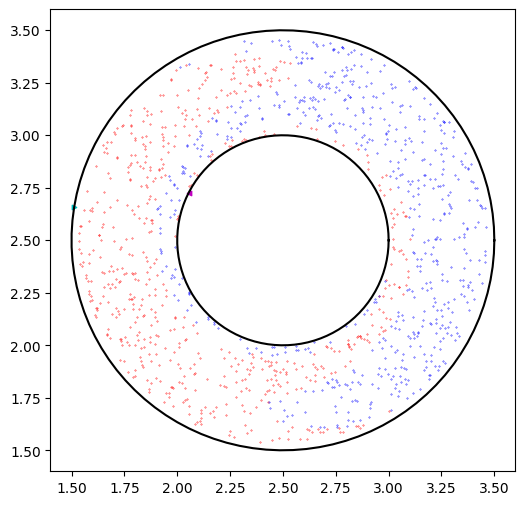

In [63]:
MD_trajectories = trajectory.MD_var.position
import matplotlib.pyplot as plt

timess = loc*inner_steps*dt
print(timess)

rot = rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED

rotss = lambda t: rot(rotation_param,t)
rot_rate = jax.jacrev(rotss)
myth = rot_rate(timess)

plt.clf()
colors = ['r','b']
loc=9
xsi = domain[0][1]/2.0
fig,am=plt.subplots(figsize=(6,6))
am.plot(MD_trajectories[loc][:num_distrib,0],MD_trajectories[loc][:num_distrib,1],'o',color=colors[0],markersize=0.3)
am.plot(MD_trajectories[loc][num_distrib:2*num_distrib,0],MD_trajectories[loc][num_distrib:2*num_distrib,1],'o',color=colors[1],markersize=0.3)
#am = plt.plot(MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,0],MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,1],'ok')
#am = plt.plot(Inner_Rad*+trajectories[i][-1,0],trajectories[i][-1,1],'m')
#circle1 = plt.Circle((trajectories[i][-1,0],trajectories[i][-1,1] ), Inner_Rad, color='c')
# am = plt.scatter(MD_trajectories[j][loc][-1,0],MD_trajectories[j][loc][-1,1],s=4000)
am.plot(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
am.plot(xsi+1.*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),xsi+1.0*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
am.scatter(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(myth[0]),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(myth[0]),marker='<',color='m',s=10)
am.scatter(xsi+1.*jnp.cos(myth[1]),xsi+1.*jnp.sin(myth[1]),marker='>',color='c',s=10)


In [64]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython import display
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
fps=1
fig10 = plt.figure(dpi=400,figsize=(8/2,8/2))
rot = rotation_Foil_Fourier_Dotted_Mutliple_NORMALIZED

xsi = domain[0][1]/2
def animate(i):

        print(i)
        loc = i
        timess = loc*inner_steps*dt
        print(timess,MD_trajectories[i][0])
        myth = rot(rotation_param,timess)
        #print('Trajectory',loc,timess,myth)

        plt.clf()
        colors = ['r','b']
        j=0
        plt.xlim([1.49,3.51])
        plt.ylim([1.49,3.51])
        am =plt.plot(MD_trajectories[loc][:num_distrib,0],MD_trajectories[loc][:num_distrib,1],'o',color=colors[0],markersize=0.3)
        am =plt.plot(MD_trajectories[loc][num_distrib:2*num_distrib,0],MD_trajectories[loc][num_distrib:2*num_distrib,1],'o',color=colors[1],markersize=0.3)
        #am = plt.plot(MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,0],MD_trajectories[loc][2*num_distrib:2*num_distrib+num_outer_bc,1],'ok')
        #am = plt.plot(Inner_Rad*+trajectories[i][-1,0],trajectories[i][-1,1],'m')
        #circle1 = plt.Circle((trajectories[i][-1,0],trajectories[i][-1,1] ), Inner_Rad, color='c')
       # am = plt.scatter(MD_trajectories[j][loc][-1,0],MD_trajectories[j][loc][-1,1],s=4000)
        am = plt.plot(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
        am = plt.plot(xsi+1.*jnp.cos(jnp.linspace(0,2*jnp.pi,100)),xsi+1.0*jnp.sin(jnp.linspace(0,2*jnp.pi,100)),'-k')
        am = plt.scatter(MD_trajectories[loc][-1,0]+rad_ratio*jnp.cos(myth[0]),MD_trajectories[loc][-1,1]+rad_ratio*jnp.sin(myth[0]),marker='<',color='m',s=10)
        am = plt.scatter(xsi+1.*jnp.cos(myth[1]),xsi+1.*jnp.sin(myth[1]),marker='>',color='c',s=10)

        return am
new_outer =len(MD_trajectories)
ani = animation.FuncAnimation(fig10, animate, frames=new_outer,interval = 1000/fps,repeat=False,blit=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

0
0.0 [2.443054  3.1663036]
0
0.0 [2.443054  3.1663036]
1
0.08 [2.4276845 3.1642041]
2
0.16 [2.3623877 3.1533513]
3
0.24000000000000002 [2.2549965 3.1201618]
4
0.32 [2.1230633 3.0485842]
5
0.4 [1.9897509 2.926111 ]
6
0.48000000000000004 [1.8840829 2.7500865]
7
0.56 [1.8355231 2.5319986]
8
0.64 [1.8663638 2.2966347]
9
0.7200000000000001 [1.985843  2.0778327]
